# EPL Data Prep

In [1]:
import pymysql.cursors
import tensorflow as tf
import pandas as pd 
import qgrid
import pw 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_tqdm import TQDMNotebookCallback
import numpy as np

from tensorflow.keras.models import model_from_json
json_file = open('regressor.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
regressor = model_from_json(loaded_model_json)
regressor.load_weights("regressor.h5")
 
grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100, 'minVisibleRows': 10}

connection = pymysql.connect(host=pw.srv,
                         user=pw.usr,
                         password=pw.pwrd,
                         db=pw.db,
                         charset='utf8mb4',
                         cursorclass=pymysql.cursors.DictCursor)
def cum_sum (df,groupby_lst,field):
    df['temp'] = df.groupby(groupby_lst)[field].cumsum()
    return df.groupby(groupby_lst)['temp'].shift(1).fillna(0)

def rolled_mean (df,groupby_lst,field, n_months, num_shift):
    _tempDf = pd.DataFrame(df.groupby(groupby_lst)[field].rolling(n_months).mean().reset_index())
    return _tempDf.groupby(groupby_lst)[field].shift(1)

def f(x):
    if x == 0:
        return 0
    elif x == 1:
        return 1
    elif x == 3:
        return 2  
    
def h_goals(row):
    if (row['was_home'] == 1):
        return row['goals_for']
    else:
        return 0 
    
def a_goals(row):
    if (row['was_home'] == 0):
        return row['goals_for']
    else:
        return 0 
    
df= pd.read_sql(""" CALL `epl`.`sp_match_agg_avg_curr`(); """, con=connection)
team_lookup = pd.read_sql(""" SELECT code as id, name FROM epl.tbl_team_info_2018_2019; """, con=connection)  

df['sf'] = str(df['fixture']) + df['season']

 
df['y_vector'] = df.apply(lambda row: f(row['result']), axis=1)

df['win_a'] = df['result'].apply(lambda x: 1 if x == 3 else 0)
df['draw_a'] = df['result'].apply(lambda x: 1 if x == 1 else 0)
df['loss_a'] = df['result'].apply(lambda x: 1 if x == 0 else 0)


filedOrder = ['season','team_id']
numRoll = 3

df['sf'] = df['fixture'].apply(str) + df['season']
df['kp_avg'] = rolled_mean(df,filedOrder,'key_passes',numRoll,1)
df['atp_var'] = df.big_chances_created + df.big_chances_missed + df.target_missed
df['atp_avg'] = rolled_mean(df,filedOrder,'atp_var',numRoll,1)
df['cbi_avg'] = rolled_mean(df,filedOrder,'clearances_blocks_interceptions',numRoll,1)
df['bcc_avg'] = rolled_mean(df,filedOrder,'big_chances_created',numRoll,1)
df['bcm_avg'] = rolled_mean(df,filedOrder,'big_chances_missed',numRoll,1)
df['gf_avg'] = rolled_mean(df,filedOrder,'goals_for',numRoll,1)
df['a_avg'] = rolled_mean(df,filedOrder,'assists',numRoll,1)
df['cp_avg'] = rolled_mean(df,filedOrder,'completed_passes',numRoll,1)
df['ap_avg'] = rolled_mean(df,filedOrder,'attempted_passes',numRoll,1)
df['ap_avg_sq'] = df['ap_avg']**2 
df['pa_avg'] = df['cp_avg']/df['ap_avg']
df['elg_avg'] = rolled_mean(df,filedOrder,'errors_leading_to_goal',numRoll,1)
df['f_avg'] = rolled_mean(df,filedOrder,'fouls',numRoll,1)
df['r_avg'] = rolled_mean(df,filedOrder,'recoveries',numRoll,1)
df['s_avg'] = rolled_mean(df,filedOrder,'saves',numRoll,1)
df['bps_avg'] = rolled_mean(df,filedOrder,'bps',numRoll,1)
df['tgm_avg'] = rolled_mean(df,filedOrder,'target_missed',numRoll,1)
df['cs_avg'] = cum_sum(df,filedOrder,'clean_sheets')
df['win'] = cum_sum(df,filedOrder,'win_a')
df['draw'] = cum_sum(df,filedOrder,'draw_a')
df['loss'] = cum_sum(df,filedOrder,'loss_a')
df['points'] = cum_sum(df,filedOrder,'result')
df['goals_for_reg'] = df['goals_for'] 
df['goals_ag_reg'] = df['goals_against'] 
df['goals_for'] = cum_sum(df,filedOrder,'goals_for')  
df['goals_against'] = cum_sum(df,filedOrder,'goals_against')  
df['goaldiff'] = cum_sum(df,filedOrder,'goals_for')  - cum_sum(df,filedOrder,'goals_against')  

df['h_gf'] = df.apply(h_goals, axis=1)
df['h_gf'] = cum_sum(df,filedOrder,'h_gf')


df['a_gf'] = df.apply(a_goals, axis=1)
df['a_gf'] = cum_sum(df,filedOrder,'a_gf')

prev = next(df.iterrows())[1]
win_streak = []

for index, row in df.iterrows():
    if row['match_day'] == 1 and row['result']== 3:
        streak = 1
        win_streak.append(streak)
    elif row['match_day'] == 1 and row['result'] != 3:
        streak =0
        win_streak.append(streak)
    elif prev['result'] != 3 and row['result'] ==2:
        streak = 1
        win_streak.append(streak)
    elif prev['result'] == 3 and row['result'] ==3:
        streak += 1
        win_streak.append(streak)
    else:
        streak = 0
        win_streak.append(streak)
    prev = row
    

scaler = MinMaxScaler()
encoder = LabelEncoder ()   
    
    
df['winstreak'] = win_streak
df['winstreak'] = df.groupby(filedOrder)['winstreak'].shift(1)


xgprep = df.dropna(subset=['cp_avg','ap_avg','ap_avg_sq','pa_avg','kp_avg','atp_avg'])

xg_df = pd.DataFrame(np.float64(regressor.predict(
                     scaler.fit_transform(xgprep[['cp_avg','ap_avg','ap_avg_sq','pa_avg','kp_avg','atp_avg']]))),index=xgprep.index,columns=['xG'])

df = pd.merge(df, xg_df, how='left', left_index=True, right_index=True)

home_df = pd.merge(df.where(df['was_home']== 1).dropna(), df.where(df['was_home']== 0).dropna(), how='inner', on=['sf'])
away_df = pd.merge(df.where(df['was_home']== 0).dropna(), df.where(df['was_home']== 1).dropna(), how='inner', on=['sf'])
all_df = pd.concat([home_df,away_df])

h_prep_df= (home_df[['sf','team_id_x', 'team_id_y', 'season_x','match_day_x','y_vector_x', 'goaldiff_x',
                      'ap_avg_x','xG_x','cp_avg_x','win_x','pa_avg_x','goals_for_x','goaldiff_y','pa_avg_y',
                      'ap_avg_y','cp_avg_y','xG_y']].dropna())

a_prep_df= (away_df[['y_vector_x','winstreak_x','sf','team_id_x','goaldiff_x','cp_avg_x','ap_avg_x','pa_avg_x','bps_avg_x',
                     'a_avg_x','ap_avg_y','cp_avg_y','goaldiff_y','pa_avg_y','win_y','loss_x']].dropna()) 
 

#learn_prep_df['rslt_num'] = encoder.fit_transform(learn_prep_df['result_x'])
X_h = h_prep_df
Y_h = h_prep_df[['y_vector_x','sf']]

X_a = a_prep_df[[ 'sf','team_id_x','winstreak_x','goaldiff_x','cp_avg_x','ap_avg_x','pa_avg_x','bps_avg_x',
                     'a_avg_x','ap_avg_y','cp_avg_y','goaldiff_y','pa_avg_y','win_y','loss_x']]

#X = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns) 
X_h_train, X_h_test, Y_h_train, Y_h_test = train_test_split(X_h, Y_h, test_size=0.40,shuffle=True)

X_a_train = a_prep_df[a_prep_df['sf'].isin(X_h_train['sf'])].drop(columns=['y_vector_x','team_id_x','sf']) 
X_a_test = a_prep_df[a_prep_df['sf'].isin(X_h_test['sf'])].drop(columns=['y_vector_x','team_id_x','sf']) 
Y_a_train = a_prep_df[a_prep_df['sf'].isin(Y_h_train['sf'])]['y_vector_x']
Y_a_test =  a_prep_df[a_prep_df['sf'].isin(Y_h_test['sf'])]['y_vector_x']

X_h_train = X_h_train.drop(columns=['sf','team_id_x', 'team_id_y', 'season_x','match_day_x','y_vector_x']) 
X_h_test = X_h_test.drop(columns=['sf','team_id_x', 'team_id_y', 'season_x','match_day_x','y_vector_x'])
Y_h_train = Y_h_train.drop(columns=['sf'])
Y_h_test = Y_h_test.drop(columns=['sf'])


X_a_train = pd.DataFrame(scaler.fit_transform(X_a_train), index=X_a_train.index, columns=X_a_train.columns) 
X_a_test = pd.DataFrame(scaler.fit_transform(X_a_test), index=X_a_test.index, columns=X_a_test.columns) 
X_h_train = pd.DataFrame(scaler.fit_transform(X_h_train), index=X_h_train.index, columns=X_h_train.columns) 
X_h_test = pd.DataFrame(scaler.fit_transform(X_h_test), index=X_h_test.index, columns=X_h_test.columns) 

#For Keras
Y_keras_train = to_categorical(Y_h_train, num_classes=None)
Y_keras_test = to_categorical(Y_h_test, num_classes=None)

qgrid.show_grid(h_prep_df.corr(),grid_options=grid_options,precision=2)

Using TensorFlow backend.


QgridWidget(grid_options={'maxVisibleRows': 15, 'editable': True, 'enableColumnReorder': False, 'minVisibleRow…

# Visualizing Correlations with Bokeh

In [2]:
from bokeh.plotting import *
from bokeh.layouts import column, row, widgetbox
from bokeh.models import CustomJS,HoverTool,ColumnDataSource
from bokeh.palettes import d3
from bokeh.transform import factor_cmap, factor_mark
from bokeh.models.widgets import CheckboxGroup
output_notebook()

h_prep_df2 = pd.merge(team_lookup,home_df, how='inner', left_on=['id'], right_on=['team_id_x'])
h_prep_df2 = pd.merge(h_prep_df2,team_lookup, how='inner', left_on=['team_id_y'], right_on=['id'])

tools = "pan,wheel_zoom,box_zoom,reset,save"
                 
def cats(x):
    if x == 0:
        return "Loss"
    elif x == 1:
        return "Draw"
    elif x == 2:
        return "Win"

h_prep_df2['label'] =  h_prep_df2['y_vector_x'].apply(cats)  

hover = HoverTool(tooltips=[
    ("Team", "@name_x"),
    ("Opponent", "@name_y"),
    ("Season", "@season_x"),
    ("Match Day", "@match_day_x"),
    ("(Expected Goals, Expected Goals Opp)", "(@xG_x, @xG_y)"),
    ('Result', '@label'),
])

source = ColumnDataSource(h_prep_df2)
orig_source = ColumnDataSource(h_prep_df2)

checkbox = CheckboxGroup(labels=h_prep_df2.name_y.unique().tolist())

x = 'xG_x'
y = 'xG_y'
 

checkbox.callback = CustomJS(args=dict(labels=checkbox.labels,source=source,orig=orig_source,x=x,y=y), code="""
   
    const d = orig.data;
    var n;
    currentLabels = []
    for (n in cb_obj.active){
             currentLabels.push(labels[cb_obj.active[n]])
    }     
    
    var index = [] 
    
    for (l in currentLabels) {    
        for(indx in d['name_x']){
            if (d['name_x'][indx] == currentLabels[l]) {
                index.push(indx)
            }
        }
 
    }   
        var temp = []        
        for (var col in orig.data){
            for (var i = 0; i < index.length; i++) {
                 temp.push(orig.data[col][index[i]])
                 }
                 source.data[col] = temp
                 console.log(source.data)
                 temp = []
            } 
        
         
        source.change.emit();
   
""")

#team_selection.js_on_change('active',update)

palette = d3['Category20'][len(h_prep_df2.name_x.unique())]
MARKERS = ['x', 'circle', 'triangle']

p = figure(plot_width=850, plot_height=600,tools=tools)
p.add_tools(hover)



p.scatter(x=x, y=y,size=10,
          color=factor_cmap('name_x', palette, h_prep_df2.name_x.unique()),
          marker=factor_mark('label', MARKERS, h_prep_df2.label.unique()),
          legend='label', source=source)
layout = row(p, widgetbox(checkbox))

show(layout)



Loading BokehJS ...

# Expected Goals Regressor

In [3]:
X = df.dropna()

X_h_reg = X[['cp_avg','ap_avg','ap_avg_sq','pa_avg','kp_avg','atp_avg']]
Y_h_reg= X[['goals_for_reg']]
    
X_h_train_reg, X_h_test_reg, Y_h_train_reg, Y_h_test_reg = train_test_split(X_h_reg, Y_h_reg, test_size=0.30,shuffle=True)
 
X_h_train_reg = pd.DataFrame(scaler.fit_transform(X_h_train_reg), index=X_h_train_reg.index, columns=X_h_train_reg.columns) 
X_h_test_reg = pd.DataFrame(scaler.fit_transform(X_h_test_reg), index=X_h_test_reg.index, columns=X_h_test_reg.columns) 

regressor = Sequential()
regressor.add(Dense(units=6, input_dim=6))
regressor.add(Dense(units=4))
regressor.add(Dense(units=1))
regressor.compile(optimizer='adam', loss='mean_squared_error',  metrics=['mae','accuracy'])
regressor.fit(X_h_train_reg, Y_h_train_reg, epochs=1000, batch_size=40, verbose=2)

regressor_json = regressor.to_json()
with open("regressor.json", "w") as json_file:
    json_file.write(regressor_json)
# serialize weights to HDF5
regressor.save_weights("regressor.h5")
print("Saved model to disk")

Epoch 1/1000
 - 0s - loss: 3.9284 - mean_absolute_error: 1.5179 - acc: 0.2932
Epoch 2/1000
 - 0s - loss: 2.4706 - mean_absolute_error: 1.1714 - acc: 0.3056
Epoch 3/1000
 - 0s - loss: 1.7470 - mean_absolute_error: 0.9918 - acc: 0.3290
Epoch 4/1000
 - 0s - loss: 1.5050 - mean_absolute_error: 0.9458 - acc: 0.3228
Epoch 5/1000
 - 0s - loss: 1.4669 - mean_absolute_error: 0.9544 - acc: 0.3214
Epoch 6/1000
 - 0s - loss: 1.4644 - mean_absolute_error: 0.9533 - acc: 0.3214
Epoch 7/1000
 - 0s - loss: 1.4612 - mean_absolute_error: 0.9580 - acc: 0.3214
Epoch 8/1000
 - 0s - loss: 1.4621 - mean_absolute_error: 0.9564 - acc: 0.3214
Epoch 9/1000
 - 0s - loss: 1.4617 - mean_absolute_error: 0.9538 - acc: 0.3214
Epoch 10/1000
 - 0s - loss: 1.4619 - mean_absolute_error: 0.9612 - acc: 0.3214
Epoch 11/1000
 - 0s - loss: 1.4596 - mean_absolute_error: 0.9580 - acc: 0.3214
Epoch 12/1000
 - 0s - loss: 1.4599 - mean_absolute_error: 0.9542 - acc: 0.3214
Epoch 13/1000
 - 0s - loss: 1.4586 - mean_absolute_error: 0.9

Epoch 105/1000
 - 0s - loss: 1.4476 - mean_absolute_error: 0.9552 - acc: 0.3214
Epoch 106/1000
 - 0s - loss: 1.4500 - mean_absolute_error: 0.9510 - acc: 0.3214
Epoch 107/1000
 - 0s - loss: 1.4472 - mean_absolute_error: 0.9536 - acc: 0.3214
Epoch 108/1000
 - 0s - loss: 1.4472 - mean_absolute_error: 0.9508 - acc: 0.3214
Epoch 109/1000
 - 0s - loss: 1.4489 - mean_absolute_error: 0.9546 - acc: 0.3214
Epoch 110/1000
 - 0s - loss: 1.4483 - mean_absolute_error: 0.9485 - acc: 0.3214
Epoch 111/1000
 - 0s - loss: 1.4523 - mean_absolute_error: 0.9595 - acc: 0.3214
Epoch 112/1000
 - 0s - loss: 1.4483 - mean_absolute_error: 0.9489 - acc: 0.3214
Epoch 113/1000
 - 0s - loss: 1.4471 - mean_absolute_error: 0.9505 - acc: 0.3214
Epoch 114/1000
 - 0s - loss: 1.4470 - mean_absolute_error: 0.9529 - acc: 0.3214
Epoch 115/1000
 - 0s - loss: 1.4465 - mean_absolute_error: 0.9483 - acc: 0.3214
Epoch 116/1000
 - 0s - loss: 1.4468 - mean_absolute_error: 0.9548 - acc: 0.3214
Epoch 117/1000
 - 0s - loss: 1.4469 - me

Epoch 208/1000
 - 0s - loss: 1.4492 - mean_absolute_error: 0.9593 - acc: 0.3214
Epoch 209/1000
 - 0s - loss: 1.4482 - mean_absolute_error: 0.9494 - acc: 0.3214
Epoch 210/1000
 - 0s - loss: 1.4469 - mean_absolute_error: 0.9477 - acc: 0.3214
Epoch 211/1000
 - 0s - loss: 1.4468 - mean_absolute_error: 0.9542 - acc: 0.3214
Epoch 212/1000
 - 0s - loss: 1.4489 - mean_absolute_error: 0.9516 - acc: 0.3214
Epoch 213/1000
 - 0s - loss: 1.4478 - mean_absolute_error: 0.9535 - acc: 0.3214
Epoch 214/1000
 - 0s - loss: 1.4461 - mean_absolute_error: 0.9509 - acc: 0.3214
Epoch 215/1000
 - 0s - loss: 1.4478 - mean_absolute_error: 0.9496 - acc: 0.3214
Epoch 216/1000
 - 0s - loss: 1.4490 - mean_absolute_error: 0.9583 - acc: 0.3214
Epoch 217/1000
 - 0s - loss: 1.4472 - mean_absolute_error: 0.9505 - acc: 0.3214
Epoch 218/1000
 - 0s - loss: 1.4460 - mean_absolute_error: 0.9532 - acc: 0.3214
Epoch 219/1000
 - 0s - loss: 1.4484 - mean_absolute_error: 0.9492 - acc: 0.3214
Epoch 220/1000
 - 0s - loss: 1.4480 - me

Epoch 311/1000
 - 0s - loss: 1.4498 - mean_absolute_error: 0.9483 - acc: 0.3214
Epoch 312/1000
 - 0s - loss: 1.4462 - mean_absolute_error: 0.9543 - acc: 0.3214
Epoch 313/1000
 - 0s - loss: 1.4467 - mean_absolute_error: 0.9451 - acc: 0.3214
Epoch 314/1000
 - 0s - loss: 1.4498 - mean_absolute_error: 0.9600 - acc: 0.3214
Epoch 315/1000
 - 0s - loss: 1.4456 - mean_absolute_error: 0.9486 - acc: 0.3214
Epoch 316/1000
 - 0s - loss: 1.4467 - mean_absolute_error: 0.9526 - acc: 0.3214
Epoch 317/1000
 - 0s - loss: 1.4469 - mean_absolute_error: 0.9507 - acc: 0.3214
Epoch 318/1000
 - 0s - loss: 1.4498 - mean_absolute_error: 0.9550 - acc: 0.3214
Epoch 319/1000
 - 0s - loss: 1.4463 - mean_absolute_error: 0.9532 - acc: 0.3214
Epoch 320/1000
 - 0s - loss: 1.4489 - mean_absolute_error: 0.9554 - acc: 0.3214
Epoch 321/1000
 - 0s - loss: 1.4487 - mean_absolute_error: 0.9529 - acc: 0.3214
Epoch 322/1000
 - 0s - loss: 1.4496 - mean_absolute_error: 0.9526 - acc: 0.3214
Epoch 323/1000
 - 0s - loss: 1.4467 - me

Epoch 414/1000
 - 0s - loss: 1.4475 - mean_absolute_error: 0.9601 - acc: 0.3214
Epoch 415/1000
 - 0s - loss: 1.4509 - mean_absolute_error: 0.9429 - acc: 0.3214
Epoch 416/1000
 - 0s - loss: 1.4492 - mean_absolute_error: 0.9496 - acc: 0.3214
Epoch 417/1000
 - 0s - loss: 1.4457 - mean_absolute_error: 0.9521 - acc: 0.3214
Epoch 418/1000
 - 0s - loss: 1.4473 - mean_absolute_error: 0.9516 - acc: 0.3214
Epoch 419/1000
 - 0s - loss: 1.4496 - mean_absolute_error: 0.9527 - acc: 0.3214
Epoch 420/1000
 - 0s - loss: 1.4479 - mean_absolute_error: 0.9468 - acc: 0.3214
Epoch 421/1000
 - 0s - loss: 1.4466 - mean_absolute_error: 0.9527 - acc: 0.3214
Epoch 422/1000
 - 0s - loss: 1.4468 - mean_absolute_error: 0.9531 - acc: 0.3214
Epoch 423/1000
 - 0s - loss: 1.4457 - mean_absolute_error: 0.9514 - acc: 0.3214
Epoch 424/1000
 - 0s - loss: 1.4486 - mean_absolute_error: 0.9540 - acc: 0.3214
Epoch 425/1000
 - 0s - loss: 1.4464 - mean_absolute_error: 0.9477 - acc: 0.3214
Epoch 426/1000
 - 0s - loss: 1.4460 - me

Epoch 517/1000
 - 0s - loss: 1.4464 - mean_absolute_error: 0.9539 - acc: 0.3214
Epoch 518/1000
 - 0s - loss: 1.4468 - mean_absolute_error: 0.9463 - acc: 0.3214
Epoch 519/1000
 - 0s - loss: 1.4486 - mean_absolute_error: 0.9552 - acc: 0.3214
Epoch 520/1000
 - 0s - loss: 1.4457 - mean_absolute_error: 0.9547 - acc: 0.3214
Epoch 521/1000
 - 0s - loss: 1.4465 - mean_absolute_error: 0.9472 - acc: 0.3214
Epoch 522/1000
 - 0s - loss: 1.4468 - mean_absolute_error: 0.9571 - acc: 0.3214
Epoch 523/1000
 - 0s - loss: 1.4475 - mean_absolute_error: 0.9480 - acc: 0.3214
Epoch 524/1000
 - 0s - loss: 1.4472 - mean_absolute_error: 0.9510 - acc: 0.3214
Epoch 525/1000
 - 0s - loss: 1.4456 - mean_absolute_error: 0.9506 - acc: 0.3214
Epoch 526/1000
 - 0s - loss: 1.4473 - mean_absolute_error: 0.9578 - acc: 0.3214
Epoch 527/1000
 - 0s - loss: 1.4471 - mean_absolute_error: 0.9447 - acc: 0.3214
Epoch 528/1000
 - 0s - loss: 1.4466 - mean_absolute_error: 0.9502 - acc: 0.3214
Epoch 529/1000
 - 0s - loss: 1.4473 - me

Epoch 620/1000
 - 0s - loss: 1.4478 - mean_absolute_error: 0.9557 - acc: 0.3214
Epoch 621/1000
 - 0s - loss: 1.4465 - mean_absolute_error: 0.9513 - acc: 0.3214
Epoch 622/1000
 - 0s - loss: 1.4470 - mean_absolute_error: 0.9511 - acc: 0.3214
Epoch 623/1000
 - 0s - loss: 1.4467 - mean_absolute_error: 0.9493 - acc: 0.3214
Epoch 624/1000
 - 0s - loss: 1.4466 - mean_absolute_error: 0.9502 - acc: 0.3214
Epoch 625/1000
 - 0s - loss: 1.4454 - mean_absolute_error: 0.9512 - acc: 0.3214
Epoch 626/1000
 - 0s - loss: 1.4464 - mean_absolute_error: 0.9533 - acc: 0.3214
Epoch 627/1000
 - 0s - loss: 1.4458 - mean_absolute_error: 0.9508 - acc: 0.3214
Epoch 628/1000
 - 0s - loss: 1.4453 - mean_absolute_error: 0.9503 - acc: 0.3214
Epoch 629/1000
 - 0s - loss: 1.4486 - mean_absolute_error: 0.9553 - acc: 0.3214
Epoch 630/1000
 - 0s - loss: 1.4457 - mean_absolute_error: 0.9487 - acc: 0.3214
Epoch 631/1000
 - 0s - loss: 1.4463 - mean_absolute_error: 0.9537 - acc: 0.3214
Epoch 632/1000
 - 0s - loss: 1.4455 - me

Epoch 723/1000
 - 0s - loss: 1.4467 - mean_absolute_error: 0.9561 - acc: 0.3214
Epoch 724/1000
 - 0s - loss: 1.4459 - mean_absolute_error: 0.9499 - acc: 0.3214
Epoch 725/1000
 - 0s - loss: 1.4452 - mean_absolute_error: 0.9502 - acc: 0.3214
Epoch 726/1000
 - 0s - loss: 1.4470 - mean_absolute_error: 0.9534 - acc: 0.3214
Epoch 727/1000
 - 0s - loss: 1.4460 - mean_absolute_error: 0.9545 - acc: 0.3214
Epoch 728/1000
 - 0s - loss: 1.4465 - mean_absolute_error: 0.9487 - acc: 0.3214
Epoch 729/1000
 - 0s - loss: 1.4474 - mean_absolute_error: 0.9500 - acc: 0.3214
Epoch 730/1000
 - 0s - loss: 1.4484 - mean_absolute_error: 0.9563 - acc: 0.3214
Epoch 731/1000
 - 0s - loss: 1.4454 - mean_absolute_error: 0.9515 - acc: 0.3214
Epoch 732/1000
 - 0s - loss: 1.4459 - mean_absolute_error: 0.9483 - acc: 0.3214
Epoch 733/1000
 - 0s - loss: 1.4475 - mean_absolute_error: 0.9565 - acc: 0.3214
Epoch 734/1000
 - 0s - loss: 1.4469 - mean_absolute_error: 0.9544 - acc: 0.3214
Epoch 735/1000
 - 0s - loss: 1.4459 - me

Epoch 826/1000
 - 0s - loss: 1.4466 - mean_absolute_error: 0.9520 - acc: 0.3214
Epoch 827/1000
 - 0s - loss: 1.4453 - mean_absolute_error: 0.9507 - acc: 0.3214
Epoch 828/1000
 - 0s - loss: 1.4464 - mean_absolute_error: 0.9530 - acc: 0.3214
Epoch 829/1000
 - 0s - loss: 1.4458 - mean_absolute_error: 0.9481 - acc: 0.3214
Epoch 830/1000
 - 0s - loss: 1.4472 - mean_absolute_error: 0.9515 - acc: 0.3214
Epoch 831/1000
 - 0s - loss: 1.4469 - mean_absolute_error: 0.9560 - acc: 0.3214
Epoch 832/1000
 - 0s - loss: 1.4474 - mean_absolute_error: 0.9508 - acc: 0.3214
Epoch 833/1000
 - 0s - loss: 1.4470 - mean_absolute_error: 0.9563 - acc: 0.3214
Epoch 834/1000
 - 0s - loss: 1.4480 - mean_absolute_error: 0.9544 - acc: 0.3214
Epoch 835/1000
 - 0s - loss: 1.4457 - mean_absolute_error: 0.9473 - acc: 0.3214
Epoch 836/1000
 - 0s - loss: 1.4458 - mean_absolute_error: 0.9535 - acc: 0.3214
Epoch 837/1000
 - 0s - loss: 1.4473 - mean_absolute_error: 0.9561 - acc: 0.3214
Epoch 838/1000
 - 0s - loss: 1.4455 - me

Epoch 929/1000
 - 0s - loss: 1.4462 - mean_absolute_error: 0.9538 - acc: 0.3214
Epoch 930/1000
 - 0s - loss: 1.4459 - mean_absolute_error: 0.9461 - acc: 0.3214
Epoch 931/1000
 - 0s - loss: 1.4461 - mean_absolute_error: 0.9545 - acc: 0.3214
Epoch 932/1000
 - 0s - loss: 1.4472 - mean_absolute_error: 0.9493 - acc: 0.3214
Epoch 933/1000
 - 0s - loss: 1.4468 - mean_absolute_error: 0.9544 - acc: 0.3214
Epoch 934/1000
 - 0s - loss: 1.4454 - mean_absolute_error: 0.9504 - acc: 0.3214
Epoch 935/1000
 - 0s - loss: 1.4464 - mean_absolute_error: 0.9485 - acc: 0.3214
Epoch 936/1000
 - 0s - loss: 1.4468 - mean_absolute_error: 0.9534 - acc: 0.3214
Epoch 937/1000
 - 0s - loss: 1.4451 - mean_absolute_error: 0.9509 - acc: 0.3214
Epoch 938/1000
 - 0s - loss: 1.4476 - mean_absolute_error: 0.9560 - acc: 0.3214
Epoch 939/1000
 - 0s - loss: 1.4473 - mean_absolute_error: 0.9451 - acc: 0.3214
Epoch 940/1000
 - 0s - loss: 1.4456 - mean_absolute_error: 0.9522 - acc: 0.3214
Epoch 941/1000
 - 0s - loss: 1.4470 - me

# Keras NN 

Epoch 1/10000
622/622 [==============================] - 0s 572us/step - loss: 0.6931 - categorical_accuracy: 0.4035
Epoch 2/10000
622/622 [==============================] - 0s 79us/step - loss: 0.6616 - categorical_accuracy: 0.5145
Epoch 3/10000
622/622 [==============================] - 0s 75us/step - loss: 0.6328 - categorical_accuracy: 0.5209
Epoch 4/10000
622/622 [==============================] - 0s 76us/step - loss: 0.6123 - categorical_accuracy: 0.4887
Epoch 5/10000
622/622 [==============================] - 0s 75us/step - loss: 0.6031 - categorical_accuracy: 0.4936
Epoch 6/10000
622/622 [==============================] - 0s 77us/step - loss: 0.5977 - categorical_accuracy: 0.5129
Epoch 7/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5941 - categorical_accuracy: 0.5225
Epoch 8/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5910 - categorical_accuracy: 0.5338
Epoch 9/10000
622/622 [==============================] - 0s 76us/step -

622/622 [==============================] - 0s 77us/step - loss: 0.5531 - categorical_accuracy: 0.5691
Epoch 72/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5527 - categorical_accuracy: 0.5740
Epoch 73/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5526 - categorical_accuracy: 0.5691
Epoch 74/10000
622/622 [==============================] - 0s 75us/step - loss: 0.5525 - categorical_accuracy: 0.5707
Epoch 75/10000
622/622 [==============================] - 0s 74us/step - loss: 0.5528 - categorical_accuracy: 0.5691
Epoch 76/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5527 - categorical_accuracy: 0.5723
Epoch 77/10000
622/622 [==============================] - 0s 77us/step - loss: 0.5525 - categorical_accuracy: 0.5707
Epoch 78/10000
622/622 [==============================] - 0s 75us/step - loss: 0.5524 - categorical_accuracy: 0.5707
Epoch 79/10000
622/622 [==============================] - 0s 75us/step - loss: 

622/622 [==============================] - 0s 75us/step - loss: 0.5464 - categorical_accuracy: 0.5756
Epoch 210/10000
622/622 [==============================] - 0s 77us/step - loss: 0.5465 - categorical_accuracy: 0.5740
Epoch 211/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5475 - categorical_accuracy: 0.5772
Epoch 212/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5467 - categorical_accuracy: 0.5788
Epoch 213/10000
622/622 [==============================] - 0s 74us/step - loss: 0.5462 - categorical_accuracy: 0.5788
Epoch 214/10000
622/622 [==============================] - 0s 75us/step - loss: 0.5468 - categorical_accuracy: 0.5756
Epoch 215/10000
622/622 [==============================] - 0s 75us/step - loss: 0.5460 - categorical_accuracy: 0.5723
Epoch 216/10000
622/622 [==============================] - 0s 78us/step - loss: 0.5465 - categorical_accuracy: 0.5740
Epoch 217/10000
622/622 [==============================] - 0s 77us/step 

622/622 [==============================] - 0s 75us/step - loss: 0.5415 - categorical_accuracy: 0.5740
Epoch 348/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5410 - categorical_accuracy: 0.5740
Epoch 349/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5408 - categorical_accuracy: 0.5772
Epoch 350/10000
622/622 [==============================] - 0s 75us/step - loss: 0.5416 - categorical_accuracy: 0.5756
Epoch 351/10000
622/622 [==============================] - 0s 75us/step - loss: 0.5423 - categorical_accuracy: 0.5788
Epoch 352/10000
622/622 [==============================] - 0s 75us/step - loss: 0.5407 - categorical_accuracy: 0.5723
Epoch 353/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5413 - categorical_accuracy: 0.5740
Epoch 354/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5414 - categorical_accuracy: 0.5740
Epoch 355/10000
622/622 [==============================] - 0s 76us/step 

622/622 [==============================] - 0s 76us/step - loss: 0.5358 - categorical_accuracy: 0.5852
Epoch 486/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5362 - categorical_accuracy: 0.5756
Epoch 487/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5356 - categorical_accuracy: 0.5772
Epoch 488/10000
622/622 [==============================] - 0s 74us/step - loss: 0.5357 - categorical_accuracy: 0.5788
Epoch 489/10000
622/622 [==============================] - 0s 75us/step - loss: 0.5354 - categorical_accuracy: 0.5788
Epoch 490/10000
622/622 [==============================] - 0s 75us/step - loss: 0.5354 - categorical_accuracy: 0.5836
Epoch 491/10000
622/622 [==============================] - 0s 75us/step - loss: 0.5356 - categorical_accuracy: 0.5788
Epoch 492/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5356 - categorical_accuracy: 0.5788
Epoch 493/10000
622/622 [==============================] - 0s 76us/step 

622/622 [==============================] - 0s 78us/step - loss: 0.5322 - categorical_accuracy: 0.5804
Epoch 624/10000
622/622 [==============================] - 0s 75us/step - loss: 0.5303 - categorical_accuracy: 0.5916
Epoch 625/10000
622/622 [==============================] - 0s 75us/step - loss: 0.5308 - categorical_accuracy: 0.5884
Epoch 626/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5308 - categorical_accuracy: 0.5868
Epoch 627/10000
622/622 [==============================] - 0s 77us/step - loss: 0.5301 - categorical_accuracy: 0.5836
Epoch 628/10000
622/622 [==============================] - 0s 77us/step - loss: 0.5307 - categorical_accuracy: 0.5900
Epoch 629/10000
622/622 [==============================] - 0s 75us/step - loss: 0.5315 - categorical_accuracy: 0.5852
Epoch 630/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5305 - categorical_accuracy: 0.5868
Epoch 631/10000
622/622 [==============================] - 0s 78us/step 

622/622 [==============================] - 0s 75us/step - loss: 0.5259 - categorical_accuracy: 0.5965
Epoch 762/10000
622/622 [==============================] - 0s 75us/step - loss: 0.5263 - categorical_accuracy: 0.6013
Epoch 763/10000
622/622 [==============================] - 0s 77us/step - loss: 0.5258 - categorical_accuracy: 0.6013
Epoch 764/10000
622/622 [==============================] - 0s 75us/step - loss: 0.5254 - categorical_accuracy: 0.5932
Epoch 765/10000
622/622 [==============================] - 0s 77us/step - loss: 0.5258 - categorical_accuracy: 0.5965
Epoch 766/10000
622/622 [==============================] - 0s 86us/step - loss: 0.5256 - categorical_accuracy: 0.5997
Epoch 767/10000
622/622 [==============================] - 0s 84us/step - loss: 0.5257 - categorical_accuracy: 0.5981
Epoch 768/10000
622/622 [==============================] - 0s 85us/step - loss: 0.5255 - categorical_accuracy: 0.6013
Epoch 769/10000
622/622 [==============================] - 0s 88us/step 

622/622 [==============================] - 0s 75us/step - loss: 0.5210 - categorical_accuracy: 0.5997
Epoch 900/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5218 - categorical_accuracy: 0.5965
Epoch 901/10000
622/622 [==============================] - 0s 75us/step - loss: 0.5210 - categorical_accuracy: 0.6061
Epoch 902/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5223 - categorical_accuracy: 0.5981
Epoch 903/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5208 - categorical_accuracy: 0.6077
Epoch 904/10000
622/622 [==============================] - 0s 74us/step - loss: 0.5208 - categorical_accuracy: 0.6013
Epoch 905/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5208 - categorical_accuracy: 0.6109
Epoch 906/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5214 - categorical_accuracy: 0.6093
Epoch 907/10000
622/622 [==============================] - 0s 76us/step 

622/622 [==============================] - 0s 75us/step - loss: 0.5168 - categorical_accuracy: 0.6109
Epoch 1038/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5180 - categorical_accuracy: 0.6093
Epoch 1039/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5166 - categorical_accuracy: 0.6045
Epoch 1040/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5161 - categorical_accuracy: 0.6158
Epoch 1041/10000
622/622 [==============================] - 0s 79us/step - loss: 0.5161 - categorical_accuracy: 0.6061
Epoch 1042/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5175 - categorical_accuracy: 0.6061
Epoch 1043/10000
622/622 [==============================] - 0s 77us/step - loss: 0.5166 - categorical_accuracy: 0.6125
Epoch 1044/10000
622/622 [==============================] - 0s 75us/step - loss: 0.5167 - categorical_accuracy: 0.6158
Epoch 1045/10000
622/622 [==============================] - 0s 76

Epoch 1106/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5140 - categorical_accuracy: 0.6093
Epoch 1107/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5149 - categorical_accuracy: 0.6061
Epoch 1108/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5156 - categorical_accuracy: 0.6174
Epoch 1109/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5141 - categorical_accuracy: 0.6158
Epoch 1110/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5138 - categorical_accuracy: 0.6206
Epoch 1111/10000
622/622 [==============================] - 0s 75us/step - loss: 0.5136 - categorical_accuracy: 0.6109
Epoch 1112/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5146 - categorical_accuracy: 0.6125
Epoch 1113/10000
622/622 [==============================] - 0s 77us/step - loss: 0.5139 - categorical_accuracy: 0.6141
Epoch 1114/10000
622/622 [======================

Epoch 1243/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5117 - categorical_accuracy: 0.6158
Epoch 1244/10000
622/622 [==============================] - 0s 75us/step - loss: 0.5100 - categorical_accuracy: 0.6222
Epoch 1245/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5134 - categorical_accuracy: 0.6077
Epoch 1246/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5119 - categorical_accuracy: 0.6174
Epoch 1247/10000
622/622 [==============================] - 0s 77us/step - loss: 0.5105 - categorical_accuracy: 0.6158
Epoch 1248/10000
622/622 [==============================] - 0s 75us/step - loss: 0.5106 - categorical_accuracy: 0.6109
Epoch 1249/10000
622/622 [==============================] - 0s 75us/step - loss: 0.5086 - categorical_accuracy: 0.6109
Epoch 1250/10000
622/622 [==============================] - 0s 77us/step - loss: 0.5098 - categorical_accuracy: 0.6125
Epoch 1251/10000
622/622 [======================

Epoch 1380/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5072 - categorical_accuracy: 0.6125
Epoch 1381/10000
622/622 [==============================] - 0s 75us/step - loss: 0.5065 - categorical_accuracy: 0.6206
Epoch 1382/10000
622/622 [==============================] - 0s 75us/step - loss: 0.5063 - categorical_accuracy: 0.6238
Epoch 1383/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5076 - categorical_accuracy: 0.6174
Epoch 1384/10000
622/622 [==============================] - 0s 75us/step - loss: 0.5074 - categorical_accuracy: 0.6238
Epoch 1385/10000
622/622 [==============================] - 0s 74us/step - loss: 0.5069 - categorical_accuracy: 0.6222
Epoch 1386/10000
622/622 [==============================] - 0s 75us/step - loss: 0.5064 - categorical_accuracy: 0.6158
Epoch 1387/10000
622/622 [==============================] - 0s 77us/step - loss: 0.5059 - categorical_accuracy: 0.6222
Epoch 1388/10000
622/622 [======================

Epoch 1517/10000
622/622 [==============================] - 0s 75us/step - loss: 0.5035 - categorical_accuracy: 0.6238
Epoch 1518/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5058 - categorical_accuracy: 0.6206
Epoch 1519/10000
622/622 [==============================] - 0s 77us/step - loss: 0.5044 - categorical_accuracy: 0.6174
Epoch 1520/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5036 - categorical_accuracy: 0.6238
Epoch 1521/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5043 - categorical_accuracy: 0.6190
Epoch 1522/10000
622/622 [==============================] - 0s 75us/step - loss: 0.5049 - categorical_accuracy: 0.6238
Epoch 1523/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5040 - categorical_accuracy: 0.6158
Epoch 1524/10000
622/622 [==============================] - 0s 77us/step - loss: 0.5045 - categorical_accuracy: 0.6190
Epoch 1525/10000
622/622 [======================

Epoch 1654/10000
622/622 [==============================] - 0s 75us/step - loss: 0.5014 - categorical_accuracy: 0.6254
Epoch 1655/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5014 - categorical_accuracy: 0.6270
Epoch 1656/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5029 - categorical_accuracy: 0.6222
Epoch 1657/10000
622/622 [==============================] - 0s 75us/step - loss: 0.5055 - categorical_accuracy: 0.6286
Epoch 1658/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5027 - categorical_accuracy: 0.6222
Epoch 1659/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5016 - categorical_accuracy: 0.6302
Epoch 1660/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5020 - categorical_accuracy: 0.6206
Epoch 1661/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5023 - categorical_accuracy: 0.6206
Epoch 1662/10000
622/622 [======================

Epoch 1791/10000
622/622 [==============================] - 0s 76us/step - loss: 0.5003 - categorical_accuracy: 0.6270
Epoch 1792/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4997 - categorical_accuracy: 0.6158
Epoch 1793/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4983 - categorical_accuracy: 0.6350
Epoch 1794/10000
622/622 [==============================] - 0s 75us/step - loss: 0.5002 - categorical_accuracy: 0.6367
Epoch 1795/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4983 - categorical_accuracy: 0.6383
Epoch 1796/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4989 - categorical_accuracy: 0.6334
Epoch 1797/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4993 - categorical_accuracy: 0.6399
Epoch 1798/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4983 - categorical_accuracy: 0.6367
Epoch 1799/10000
622/622 [======================

Epoch 1928/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4970 - categorical_accuracy: 0.6350
Epoch 1929/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4973 - categorical_accuracy: 0.6318
Epoch 1930/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4972 - categorical_accuracy: 0.6318
Epoch 1931/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4973 - categorical_accuracy: 0.6270
Epoch 1932/10000
622/622 [==============================] - 0s 74us/step - loss: 0.4977 - categorical_accuracy: 0.6350
Epoch 1933/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4981 - categorical_accuracy: 0.6286
Epoch 1934/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4959 - categorical_accuracy: 0.6350
Epoch 1935/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4960 - categorical_accuracy: 0.6334
Epoch 1936/10000
622/622 [======================

Epoch 2065/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4942 - categorical_accuracy: 0.6399
Epoch 2066/10000
622/622 [==============================] - 0s 78us/step - loss: 0.4938 - categorical_accuracy: 0.6415
Epoch 2067/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4939 - categorical_accuracy: 0.6350
Epoch 2068/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4942 - categorical_accuracy: 0.6334
Epoch 2069/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4977 - categorical_accuracy: 0.6318
Epoch 2070/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4942 - categorical_accuracy: 0.6318
Epoch 2071/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4955 - categorical_accuracy: 0.6383
Epoch 2072/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4961 - categorical_accuracy: 0.6415
Epoch 2073/10000
622/622 [======================

Epoch 2202/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4928 - categorical_accuracy: 0.6399
Epoch 2203/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4939 - categorical_accuracy: 0.6254
Epoch 2204/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4948 - categorical_accuracy: 0.6415
Epoch 2205/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4918 - categorical_accuracy: 0.6350
Epoch 2206/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4932 - categorical_accuracy: 0.6318
Epoch 2207/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4915 - categorical_accuracy: 0.6383
Epoch 2208/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4921 - categorical_accuracy: 0.6350
Epoch 2209/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4927 - categorical_accuracy: 0.6367
Epoch 2210/10000
622/622 [======================

Epoch 2339/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4910 - categorical_accuracy: 0.6431
Epoch 2340/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4912 - categorical_accuracy: 0.6367
Epoch 2341/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4900 - categorical_accuracy: 0.6495
Epoch 2342/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4910 - categorical_accuracy: 0.6367
Epoch 2343/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4899 - categorical_accuracy: 0.6350
Epoch 2344/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4903 - categorical_accuracy: 0.6334
Epoch 2345/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4903 - categorical_accuracy: 0.6479
Epoch 2346/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4908 - categorical_accuracy: 0.6383
Epoch 2347/10000
622/622 [======================

Epoch 2476/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4878 - categorical_accuracy: 0.6350
Epoch 2477/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4881 - categorical_accuracy: 0.6415
Epoch 2478/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4870 - categorical_accuracy: 0.6399
Epoch 2479/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4889 - categorical_accuracy: 0.6415
Epoch 2480/10000
622/622 [==============================] - 0s 74us/step - loss: 0.4890 - categorical_accuracy: 0.6431
Epoch 2481/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4878 - categorical_accuracy: 0.6559
Epoch 2482/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4870 - categorical_accuracy: 0.6415
Epoch 2483/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4884 - categorical_accuracy: 0.6479
Epoch 2484/10000
622/622 [======================

Epoch 2613/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4856 - categorical_accuracy: 0.6463
Epoch 2614/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4853 - categorical_accuracy: 0.6479
Epoch 2615/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4899 - categorical_accuracy: 0.6415
Epoch 2616/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4863 - categorical_accuracy: 0.6318
Epoch 2617/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4876 - categorical_accuracy: 0.6463
Epoch 2618/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4867 - categorical_accuracy: 0.6511
Epoch 2619/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4858 - categorical_accuracy: 0.6463
Epoch 2620/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4858 - categorical_accuracy: 0.6447
Epoch 2621/10000
622/622 [======================

Epoch 2750/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4837 - categorical_accuracy: 0.6527
Epoch 2751/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4846 - categorical_accuracy: 0.6431
Epoch 2752/10000
622/622 [==============================] - 0s 74us/step - loss: 0.4834 - categorical_accuracy: 0.6559
Epoch 2753/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4865 - categorical_accuracy: 0.6479
Epoch 2754/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4841 - categorical_accuracy: 0.6543
Epoch 2755/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4845 - categorical_accuracy: 0.6511
Epoch 2756/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4845 - categorical_accuracy: 0.6495
Epoch 2757/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4834 - categorical_accuracy: 0.6527
Epoch 2758/10000
622/622 [======================

Epoch 2887/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4812 - categorical_accuracy: 0.6511
Epoch 2888/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4818 - categorical_accuracy: 0.6479
Epoch 2889/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4818 - categorical_accuracy: 0.6527
Epoch 2890/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4848 - categorical_accuracy: 0.6511
Epoch 2891/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4830 - categorical_accuracy: 0.6511
Epoch 2892/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4859 - categorical_accuracy: 0.6431
Epoch 2893/10000
622/622 [==============================] - 0s 74us/step - loss: 0.4823 - categorical_accuracy: 0.6559
Epoch 2894/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4823 - categorical_accuracy: 0.6463
Epoch 2895/10000
622/622 [======================

Epoch 3024/10000
622/622 [==============================] - 0s 78us/step - loss: 0.4787 - categorical_accuracy: 0.6495
Epoch 3025/10000
622/622 [==============================] - 0s 74us/step - loss: 0.4800 - categorical_accuracy: 0.6543
Epoch 3026/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4804 - categorical_accuracy: 0.6463
Epoch 3027/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4798 - categorical_accuracy: 0.6495
Epoch 3028/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4801 - categorical_accuracy: 0.6592
Epoch 3029/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4807 - categorical_accuracy: 0.6559
Epoch 3030/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4790 - categorical_accuracy: 0.6543
Epoch 3031/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4798 - categorical_accuracy: 0.6399
Epoch 3032/10000
622/622 [======================

Epoch 3161/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4779 - categorical_accuracy: 0.6527
Epoch 3162/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4770 - categorical_accuracy: 0.6576
Epoch 3163/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4776 - categorical_accuracy: 0.6527
Epoch 3164/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4774 - categorical_accuracy: 0.6608
Epoch 3165/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4790 - categorical_accuracy: 0.6415
Epoch 3166/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4763 - categorical_accuracy: 0.6511
Epoch 3167/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4763 - categorical_accuracy: 0.6543
Epoch 3168/10000
622/622 [==============================] - 0s 74us/step - loss: 0.4769 - categorical_accuracy: 0.6511
Epoch 3169/10000
622/622 [======================

Epoch 3298/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4744 - categorical_accuracy: 0.6592
Epoch 3299/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4754 - categorical_accuracy: 0.6495
Epoch 3300/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4778 - categorical_accuracy: 0.6431
Epoch 3301/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4766 - categorical_accuracy: 0.6479
Epoch 3302/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4747 - categorical_accuracy: 0.6543
Epoch 3303/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4768 - categorical_accuracy: 0.6479
Epoch 3304/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4790 - categorical_accuracy: 0.6576
Epoch 3305/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4808 - categorical_accuracy: 0.6511
Epoch 3306/10000
622/622 [======================

Epoch 3435/10000
622/622 [==============================] - 0s 78us/step - loss: 0.4728 - categorical_accuracy: 0.6559
Epoch 3436/10000
622/622 [==============================] - 0s 80us/step - loss: 0.4781 - categorical_accuracy: 0.6511
Epoch 3437/10000
622/622 [==============================] - 0s 80us/step - loss: 0.4743 - categorical_accuracy: 0.6431
Epoch 3438/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4726 - categorical_accuracy: 0.6592
Epoch 3439/10000
622/622 [==============================] - 0s 78us/step - loss: 0.4740 - categorical_accuracy: 0.6495
Epoch 3440/10000
622/622 [==============================] - 0s 80us/step - loss: 0.4742 - categorical_accuracy: 0.6479
Epoch 3441/10000
622/622 [==============================] - 0s 78us/step - loss: 0.4733 - categorical_accuracy: 0.6511
Epoch 3442/10000
622/622 [==============================] - 0s 78us/step - loss: 0.4727 - categorical_accuracy: 0.6576
Epoch 3443/10000
622/622 [======================

Epoch 3572/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4724 - categorical_accuracy: 0.6527
Epoch 3573/10000
622/622 [==============================] - 0s 74us/step - loss: 0.4732 - categorical_accuracy: 0.6559
Epoch 3574/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4704 - categorical_accuracy: 0.6527
Epoch 3575/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4706 - categorical_accuracy: 0.6511
Epoch 3576/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4716 - categorical_accuracy: 0.6527
Epoch 3577/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4717 - categorical_accuracy: 0.6431
Epoch 3578/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4717 - categorical_accuracy: 0.6463
Epoch 3579/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4760 - categorical_accuracy: 0.6559
Epoch 3580/10000
622/622 [======================

Epoch 3709/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4729 - categorical_accuracy: 0.6608
Epoch 3710/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4700 - categorical_accuracy: 0.6624
Epoch 3711/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4694 - categorical_accuracy: 0.6543
Epoch 3712/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4708 - categorical_accuracy: 0.6559
Epoch 3713/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4697 - categorical_accuracy: 0.6527
Epoch 3714/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4695 - categorical_accuracy: 0.6559
Epoch 3715/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4700 - categorical_accuracy: 0.6576
Epoch 3716/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4703 - categorical_accuracy: 0.6559
Epoch 3717/10000
622/622 [======================

Epoch 3846/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4696 - categorical_accuracy: 0.6495
Epoch 3847/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4697 - categorical_accuracy: 0.6656
Epoch 3848/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4684 - categorical_accuracy: 0.6559
Epoch 3849/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4677 - categorical_accuracy: 0.6576
Epoch 3850/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4686 - categorical_accuracy: 0.6592
Epoch 3851/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4683 - categorical_accuracy: 0.6592
Epoch 3852/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4727 - categorical_accuracy: 0.6511
Epoch 3853/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4676 - categorical_accuracy: 0.6640
Epoch 3854/10000
622/622 [======================

Epoch 3983/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4671 - categorical_accuracy: 0.6559
Epoch 3984/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4674 - categorical_accuracy: 0.6495
Epoch 3985/10000
622/622 [==============================] - 0s 81us/step - loss: 0.4667 - categorical_accuracy: 0.6672
Epoch 3986/10000
622/622 [==============================] - 0s 86us/step - loss: 0.4666 - categorical_accuracy: 0.6559
Epoch 3987/10000
622/622 [==============================] - 0s 82us/step - loss: 0.4676 - categorical_accuracy: 0.6592
Epoch 3988/10000
622/622 [==============================] - 0s 81us/step - loss: 0.4688 - categorical_accuracy: 0.6559
Epoch 3989/10000
622/622 [==============================] - 0s 85us/step - loss: 0.4681 - categorical_accuracy: 0.6720
Epoch 3990/10000
622/622 [==============================] - 0s 79us/step - loss: 0.4694 - categorical_accuracy: 0.6543
Epoch 3991/10000
622/622 [======================

Epoch 4120/10000
622/622 [==============================] - 0s 84us/step - loss: 0.4665 - categorical_accuracy: 0.6688
Epoch 4121/10000
622/622 [==============================] - 0s 83us/step - loss: 0.4663 - categorical_accuracy: 0.6559
Epoch 4122/10000
622/622 [==============================] - 0s 78us/step - loss: 0.4673 - categorical_accuracy: 0.6527
Epoch 4123/10000
622/622 [==============================] - 0s 79us/step - loss: 0.4663 - categorical_accuracy: 0.6592
Epoch 4124/10000
622/622 [==============================] - 0s 79us/step - loss: 0.4682 - categorical_accuracy: 0.6624
Epoch 4125/10000
622/622 [==============================] - 0s 80us/step - loss: 0.4670 - categorical_accuracy: 0.6543
Epoch 4126/10000
622/622 [==============================] - 0s 78us/step - loss: 0.4654 - categorical_accuracy: 0.6656
Epoch 4127/10000
622/622 [==============================] - 0s 79us/step - loss: 0.4654 - categorical_accuracy: 0.6592
Epoch 4128/10000
622/622 [======================

Epoch 4257/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4666 - categorical_accuracy: 0.6672
Epoch 4258/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4656 - categorical_accuracy: 0.6608
Epoch 4259/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4640 - categorical_accuracy: 0.6640
Epoch 4260/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4641 - categorical_accuracy: 0.6656
Epoch 4261/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4660 - categorical_accuracy: 0.6656
Epoch 4262/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4677 - categorical_accuracy: 0.6511
Epoch 4263/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4648 - categorical_accuracy: 0.6576
Epoch 4264/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4647 - categorical_accuracy: 0.6592
Epoch 4265/10000
622/622 [======================

Epoch 4394/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4631 - categorical_accuracy: 0.6592
Epoch 4395/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4639 - categorical_accuracy: 0.6592
Epoch 4396/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4670 - categorical_accuracy: 0.6576
Epoch 4397/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4661 - categorical_accuracy: 0.6527
Epoch 4398/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4659 - categorical_accuracy: 0.6608
Epoch 4399/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4641 - categorical_accuracy: 0.6608
Epoch 4400/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4642 - categorical_accuracy: 0.6640
Epoch 4401/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4644 - categorical_accuracy: 0.6672
Epoch 4402/10000
622/622 [======================

Epoch 4531/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4638 - categorical_accuracy: 0.6672
Epoch 4532/10000
622/622 [==============================] - 0s 74us/step - loss: 0.4629 - categorical_accuracy: 0.6704
Epoch 4533/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4628 - categorical_accuracy: 0.6608
Epoch 4534/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4640 - categorical_accuracy: 0.6479
Epoch 4535/10000
622/622 [==============================] - 0s 74us/step - loss: 0.4683 - categorical_accuracy: 0.6656
Epoch 4536/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4664 - categorical_accuracy: 0.6640
Epoch 4537/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4629 - categorical_accuracy: 0.6608
Epoch 4538/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4641 - categorical_accuracy: 0.6640
Epoch 4539/10000
622/622 [======================

Epoch 4668/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4617 - categorical_accuracy: 0.6656
Epoch 4669/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4612 - categorical_accuracy: 0.6801
Epoch 4670/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4613 - categorical_accuracy: 0.6592
Epoch 4671/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4606 - categorical_accuracy: 0.6704
Epoch 4672/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4632 - categorical_accuracy: 0.6640
Epoch 4673/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4622 - categorical_accuracy: 0.6672
Epoch 4674/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4633 - categorical_accuracy: 0.6704
Epoch 4675/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4592 - categorical_accuracy: 0.6752
Epoch 4676/10000
622/622 [======================

Epoch 4805/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4603 - categorical_accuracy: 0.6704
Epoch 4806/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4612 - categorical_accuracy: 0.6736
Epoch 4807/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4608 - categorical_accuracy: 0.6752
Epoch 4808/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4607 - categorical_accuracy: 0.6704
Epoch 4809/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4656 - categorical_accuracy: 0.6640
Epoch 4810/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4607 - categorical_accuracy: 0.6656
Epoch 4811/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4602 - categorical_accuracy: 0.6688
Epoch 4812/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4605 - categorical_accuracy: 0.6672
Epoch 4813/10000
622/622 [======================

Epoch 4942/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4605 - categorical_accuracy: 0.6720
Epoch 4943/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4586 - categorical_accuracy: 0.6688
Epoch 4944/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4633 - categorical_accuracy: 0.6640
Epoch 4945/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4604 - categorical_accuracy: 0.6624
Epoch 4946/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4638 - categorical_accuracy: 0.6704
Epoch 4947/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4618 - categorical_accuracy: 0.6576
Epoch 4948/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4607 - categorical_accuracy: 0.6656
Epoch 4949/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4630 - categorical_accuracy: 0.6608
Epoch 4950/10000
622/622 [======================

Epoch 5079/10000
622/622 [==============================] - 0s 74us/step - loss: 0.4597 - categorical_accuracy: 0.6592
Epoch 5080/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4576 - categorical_accuracy: 0.6656
Epoch 5081/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4615 - categorical_accuracy: 0.6592
Epoch 5082/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4589 - categorical_accuracy: 0.6720
Epoch 5083/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4578 - categorical_accuracy: 0.6704
Epoch 5084/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4597 - categorical_accuracy: 0.6640
Epoch 5085/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4599 - categorical_accuracy: 0.6656
Epoch 5086/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4574 - categorical_accuracy: 0.6768
Epoch 5087/10000
622/622 [======================

Epoch 5216/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4573 - categorical_accuracy: 0.6672
Epoch 5217/10000
622/622 [==============================] - 0s 78us/step - loss: 0.4580 - categorical_accuracy: 0.6752
Epoch 5218/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4586 - categorical_accuracy: 0.6672
Epoch 5219/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4564 - categorical_accuracy: 0.6801
Epoch 5220/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4573 - categorical_accuracy: 0.6768
Epoch 5221/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4620 - categorical_accuracy: 0.6511
Epoch 5222/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4593 - categorical_accuracy: 0.6608
Epoch 5223/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4559 - categorical_accuracy: 0.6688
Epoch 5224/10000
622/622 [======================

Epoch 5353/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4571 - categorical_accuracy: 0.6624
Epoch 5354/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4545 - categorical_accuracy: 0.6752
Epoch 5355/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4554 - categorical_accuracy: 0.6752
Epoch 5356/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4567 - categorical_accuracy: 0.6720
Epoch 5357/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4558 - categorical_accuracy: 0.6768
Epoch 5358/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4577 - categorical_accuracy: 0.6881
Epoch 5359/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4602 - categorical_accuracy: 0.6656
Epoch 5360/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4573 - categorical_accuracy: 0.6592
Epoch 5361/10000
622/622 [======================

Epoch 5490/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4583 - categorical_accuracy: 0.6801
Epoch 5491/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4578 - categorical_accuracy: 0.6688
Epoch 5492/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4579 - categorical_accuracy: 0.6785
Epoch 5493/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4552 - categorical_accuracy: 0.6752
Epoch 5494/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4574 - categorical_accuracy: 0.6752
Epoch 5495/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4561 - categorical_accuracy: 0.6752
Epoch 5496/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4559 - categorical_accuracy: 0.6752
Epoch 5497/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4557 - categorical_accuracy: 0.6704
Epoch 5498/10000
622/622 [======================

Epoch 5627/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4537 - categorical_accuracy: 0.6785
Epoch 5628/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4553 - categorical_accuracy: 0.6752
Epoch 5629/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4525 - categorical_accuracy: 0.6704
Epoch 5630/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4543 - categorical_accuracy: 0.6768
Epoch 5631/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4561 - categorical_accuracy: 0.6785
Epoch 5632/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4529 - categorical_accuracy: 0.6720
Epoch 5633/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4534 - categorical_accuracy: 0.6752
Epoch 5634/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4582 - categorical_accuracy: 0.6624
Epoch 5635/10000
622/622 [======================

Epoch 5764/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4527 - categorical_accuracy: 0.6801
Epoch 5765/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4526 - categorical_accuracy: 0.6752
Epoch 5766/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4544 - categorical_accuracy: 0.6768
Epoch 5767/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4524 - categorical_accuracy: 0.6817
Epoch 5768/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4529 - categorical_accuracy: 0.6688
Epoch 5769/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4516 - categorical_accuracy: 0.6801
Epoch 5770/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4534 - categorical_accuracy: 0.6688
Epoch 5771/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4544 - categorical_accuracy: 0.6752
Epoch 5772/10000
622/622 [======================

Epoch 5901/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4517 - categorical_accuracy: 0.6785
Epoch 5902/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4549 - categorical_accuracy: 0.6704
Epoch 5903/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4549 - categorical_accuracy: 0.6817
Epoch 5904/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4527 - categorical_accuracy: 0.6801
Epoch 5905/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4538 - categorical_accuracy: 0.6640
Epoch 5906/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4522 - categorical_accuracy: 0.6817
Epoch 5907/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4519 - categorical_accuracy: 0.6736
Epoch 5908/10000
622/622 [==============================] - 0s 78us/step - loss: 0.4503 - categorical_accuracy: 0.6833
Epoch 5909/10000
622/622 [======================

Epoch 6038/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4493 - categorical_accuracy: 0.6736
Epoch 6039/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4527 - categorical_accuracy: 0.6801
Epoch 6040/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4495 - categorical_accuracy: 0.6865
Epoch 6041/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4496 - categorical_accuracy: 0.6801
Epoch 6042/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4535 - categorical_accuracy: 0.6768
Epoch 6043/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4561 - categorical_accuracy: 0.6720
Epoch 6044/10000
622/622 [==============================] - 0s 78us/step - loss: 0.4505 - categorical_accuracy: 0.6785
Epoch 6045/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4510 - categorical_accuracy: 0.6801
Epoch 6046/10000
622/622 [======================

Epoch 6175/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4491 - categorical_accuracy: 0.6833
Epoch 6176/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4488 - categorical_accuracy: 0.6736
Epoch 6177/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4496 - categorical_accuracy: 0.6913
Epoch 6178/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4523 - categorical_accuracy: 0.6768
Epoch 6179/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4506 - categorical_accuracy: 0.6801
Epoch 6180/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4519 - categorical_accuracy: 0.6768
Epoch 6181/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4509 - categorical_accuracy: 0.6865
Epoch 6182/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4486 - categorical_accuracy: 0.6913
Epoch 6183/10000
622/622 [======================

Epoch 6312/10000
622/622 [==============================] - 0s 74us/step - loss: 0.4504 - categorical_accuracy: 0.6801
Epoch 6313/10000
622/622 [==============================] - 0s 74us/step - loss: 0.4508 - categorical_accuracy: 0.6833
Epoch 6314/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4471 - categorical_accuracy: 0.6913
Epoch 6315/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4472 - categorical_accuracy: 0.6865
Epoch 6316/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4493 - categorical_accuracy: 0.6817
Epoch 6317/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4488 - categorical_accuracy: 0.6849
Epoch 6318/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4488 - categorical_accuracy: 0.6849
Epoch 6319/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4471 - categorical_accuracy: 0.6768
Epoch 6320/10000
622/622 [======================

Epoch 6449/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4465 - categorical_accuracy: 0.6768
Epoch 6450/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4463 - categorical_accuracy: 0.6849
Epoch 6451/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4476 - categorical_accuracy: 0.6849
Epoch 6452/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4504 - categorical_accuracy: 0.6801
Epoch 6453/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4510 - categorical_accuracy: 0.6785
Epoch 6454/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4505 - categorical_accuracy: 0.6881
Epoch 6455/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4486 - categorical_accuracy: 0.6785
Epoch 6456/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4462 - categorical_accuracy: 0.6897
Epoch 6457/10000
622/622 [======================

Epoch 6586/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4465 - categorical_accuracy: 0.6881
Epoch 6587/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4478 - categorical_accuracy: 0.6913
Epoch 6588/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4455 - categorical_accuracy: 0.6865
Epoch 6589/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4471 - categorical_accuracy: 0.6801
Epoch 6590/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4520 - categorical_accuracy: 0.6672
Epoch 6591/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4465 - categorical_accuracy: 0.6801
Epoch 6592/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4506 - categorical_accuracy: 0.6768
Epoch 6593/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4456 - categorical_accuracy: 0.6833
Epoch 6594/10000
622/622 [======================

Epoch 6723/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4457 - categorical_accuracy: 0.6913
Epoch 6724/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4442 - categorical_accuracy: 0.6849
Epoch 6725/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4447 - categorical_accuracy: 0.6929
Epoch 6726/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4502 - categorical_accuracy: 0.6801
Epoch 6727/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4443 - categorical_accuracy: 0.6865
Epoch 6728/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4494 - categorical_accuracy: 0.6801
Epoch 6729/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4483 - categorical_accuracy: 0.6785
Epoch 6730/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4458 - categorical_accuracy: 0.6768
Epoch 6731/10000
622/622 [======================

Epoch 6860/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4464 - categorical_accuracy: 0.6833
Epoch 6861/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4498 - categorical_accuracy: 0.6785
Epoch 6862/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4448 - categorical_accuracy: 0.6849
Epoch 6863/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4449 - categorical_accuracy: 0.6945
Epoch 6864/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4449 - categorical_accuracy: 0.6817
Epoch 6865/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4434 - categorical_accuracy: 0.6897
Epoch 6866/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4442 - categorical_accuracy: 0.6929
Epoch 6867/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4436 - categorical_accuracy: 0.6945
Epoch 6868/10000
622/622 [======================

Epoch 6997/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4449 - categorical_accuracy: 0.6833
Epoch 6998/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4453 - categorical_accuracy: 0.6785
Epoch 6999/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4458 - categorical_accuracy: 0.6720
Epoch 7000/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4449 - categorical_accuracy: 0.6849
Epoch 7001/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4464 - categorical_accuracy: 0.6785
Epoch 7002/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4481 - categorical_accuracy: 0.6833
Epoch 7003/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4500 - categorical_accuracy: 0.6785
Epoch 7004/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4438 - categorical_accuracy: 0.6785
Epoch 7005/10000
622/622 [======================

Epoch 7134/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4464 - categorical_accuracy: 0.6720
Epoch 7135/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4461 - categorical_accuracy: 0.6817
Epoch 7136/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4446 - categorical_accuracy: 0.6881
Epoch 7137/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4496 - categorical_accuracy: 0.6849
Epoch 7138/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4494 - categorical_accuracy: 0.6720
Epoch 7139/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4446 - categorical_accuracy: 0.6897
Epoch 7140/10000
622/622 [==============================] - 0s 74us/step - loss: 0.4430 - categorical_accuracy: 0.6817
Epoch 7141/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4451 - categorical_accuracy: 0.6785
Epoch 7142/10000
622/622 [======================

Epoch 7271/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4446 - categorical_accuracy: 0.6833
Epoch 7272/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4462 - categorical_accuracy: 0.6785
Epoch 7273/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4419 - categorical_accuracy: 0.6913
Epoch 7274/10000
622/622 [==============================] - 0s 74us/step - loss: 0.4429 - categorical_accuracy: 0.6881
Epoch 7275/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4440 - categorical_accuracy: 0.6752
Epoch 7276/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4455 - categorical_accuracy: 0.6881
Epoch 7277/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4424 - categorical_accuracy: 0.6785
Epoch 7278/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4434 - categorical_accuracy: 0.6897
Epoch 7279/10000
622/622 [======================

Epoch 7408/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4423 - categorical_accuracy: 0.6913
Epoch 7409/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4431 - categorical_accuracy: 0.6833
Epoch 7410/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4446 - categorical_accuracy: 0.6801
Epoch 7411/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4424 - categorical_accuracy: 0.6977
Epoch 7412/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4453 - categorical_accuracy: 0.6801
Epoch 7413/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4437 - categorical_accuracy: 0.6833
Epoch 7414/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4423 - categorical_accuracy: 0.6945
Epoch 7415/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4436 - categorical_accuracy: 0.6833
Epoch 7416/10000
622/622 [======================

Epoch 7545/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4452 - categorical_accuracy: 0.6736
Epoch 7546/10000
622/622 [==============================] - 0s 74us/step - loss: 0.4443 - categorical_accuracy: 0.6656
Epoch 7547/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4442 - categorical_accuracy: 0.6688
Epoch 7548/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4394 - categorical_accuracy: 0.6961
Epoch 7549/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4413 - categorical_accuracy: 0.6752
Epoch 7550/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4412 - categorical_accuracy: 0.6929
Epoch 7551/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4420 - categorical_accuracy: 0.6881
Epoch 7552/10000
622/622 [==============================] - 0s 74us/step - loss: 0.4415 - categorical_accuracy: 0.6929
Epoch 7553/10000
622/622 [======================

Epoch 7682/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4424 - categorical_accuracy: 0.6897
Epoch 7683/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4411 - categorical_accuracy: 0.6913
Epoch 7684/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4414 - categorical_accuracy: 0.6849
Epoch 7685/10000
622/622 [==============================] - 0s 74us/step - loss: 0.4428 - categorical_accuracy: 0.6801
Epoch 7686/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4429 - categorical_accuracy: 0.6768
Epoch 7687/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4390 - categorical_accuracy: 0.6881
Epoch 7688/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4402 - categorical_accuracy: 0.6817
Epoch 7689/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4405 - categorical_accuracy: 0.6881
Epoch 7690/10000
622/622 [======================

Epoch 7819/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4433 - categorical_accuracy: 0.6801
Epoch 7820/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4399 - categorical_accuracy: 0.6961
Epoch 7821/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4413 - categorical_accuracy: 0.6881
Epoch 7822/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4403 - categorical_accuracy: 0.6817
Epoch 7823/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4409 - categorical_accuracy: 0.6994
Epoch 7824/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4407 - categorical_accuracy: 0.6833
Epoch 7825/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4429 - categorical_accuracy: 0.6752
Epoch 7826/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4423 - categorical_accuracy: 0.6881
Epoch 7827/10000
622/622 [======================

Epoch 7956/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4432 - categorical_accuracy: 0.6801
Epoch 7957/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4415 - categorical_accuracy: 0.6849
Epoch 7958/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4397 - categorical_accuracy: 0.6913
Epoch 7959/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4410 - categorical_accuracy: 0.6833
Epoch 7960/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4403 - categorical_accuracy: 0.6897
Epoch 7961/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4402 - categorical_accuracy: 0.6865
Epoch 7962/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4405 - categorical_accuracy: 0.6849
Epoch 7963/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4416 - categorical_accuracy: 0.6865
Epoch 7964/10000
622/622 [======================

Epoch 8093/10000
622/622 [==============================] - 0s 87us/step - loss: 0.4394 - categorical_accuracy: 0.6849
Epoch 8094/10000
622/622 [==============================] - 0s 79us/step - loss: 0.4412 - categorical_accuracy: 0.6849
Epoch 8095/10000
622/622 [==============================] - 0s 78us/step - loss: 0.4401 - categorical_accuracy: 0.6801
Epoch 8096/10000
622/622 [==============================] - 0s 78us/step - loss: 0.4385 - categorical_accuracy: 0.6929
Epoch 8097/10000
622/622 [==============================] - 0s 78us/step - loss: 0.4408 - categorical_accuracy: 0.6881
Epoch 8098/10000
622/622 [==============================] - 0s 79us/step - loss: 0.4391 - categorical_accuracy: 0.6785
Epoch 8099/10000
622/622 [==============================] - 0s 80us/step - loss: 0.4442 - categorical_accuracy: 0.6720
Epoch 8100/10000
622/622 [==============================] - 0s 79us/step - loss: 0.4431 - categorical_accuracy: 0.6881
Epoch 8101/10000
622/622 [======================

Epoch 8230/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4387 - categorical_accuracy: 0.6961
Epoch 8231/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4417 - categorical_accuracy: 0.6897
Epoch 8232/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4457 - categorical_accuracy: 0.6833
Epoch 8233/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4392 - categorical_accuracy: 0.6752
Epoch 8234/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4380 - categorical_accuracy: 0.6865
Epoch 8235/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4425 - categorical_accuracy: 0.6897
Epoch 8236/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4432 - categorical_accuracy: 0.6704
Epoch 8237/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4404 - categorical_accuracy: 0.6801
Epoch 8238/10000
622/622 [======================

Epoch 8367/10000
622/622 [==============================] - 0s 74us/step - loss: 0.4402 - categorical_accuracy: 0.6849
Epoch 8368/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4418 - categorical_accuracy: 0.6768
Epoch 8369/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4440 - categorical_accuracy: 0.6736
Epoch 8370/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4416 - categorical_accuracy: 0.6817
Epoch 8371/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4437 - categorical_accuracy: 0.6704
Epoch 8372/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4432 - categorical_accuracy: 0.6801
Epoch 8373/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4383 - categorical_accuracy: 0.6833
Epoch 8374/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4398 - categorical_accuracy: 0.6785
Epoch 8375/10000
622/622 [======================

Epoch 8504/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4443 - categorical_accuracy: 0.6752
Epoch 8505/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4412 - categorical_accuracy: 0.6801
Epoch 8506/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4396 - categorical_accuracy: 0.6849
Epoch 8507/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4406 - categorical_accuracy: 0.6768
Epoch 8508/10000
622/622 [==============================] - 0s 74us/step - loss: 0.4387 - categorical_accuracy: 0.6785
Epoch 8509/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4388 - categorical_accuracy: 0.6833
Epoch 8510/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4379 - categorical_accuracy: 0.6897
Epoch 8511/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4385 - categorical_accuracy: 0.6865
Epoch 8512/10000
622/622 [======================

Epoch 8641/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4369 - categorical_accuracy: 0.6929
Epoch 8642/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4377 - categorical_accuracy: 0.6977
Epoch 8643/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4360 - categorical_accuracy: 0.6977
Epoch 8644/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4370 - categorical_accuracy: 0.6881
Epoch 8645/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4374 - categorical_accuracy: 0.6817
Epoch 8646/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4422 - categorical_accuracy: 0.6897
Epoch 8647/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4402 - categorical_accuracy: 0.6720
Epoch 8648/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4395 - categorical_accuracy: 0.6768
Epoch 8649/10000
622/622 [======================

Epoch 8778/10000
622/622 [==============================] - 0s 81us/step - loss: 0.4433 - categorical_accuracy: 0.6768
Epoch 8779/10000
622/622 [==============================] - 0s 78us/step - loss: 0.4430 - categorical_accuracy: 0.6897
Epoch 8780/10000
622/622 [==============================] - 0s 79us/step - loss: 0.4377 - categorical_accuracy: 0.6945
Epoch 8781/10000
622/622 [==============================] - 0s 78us/step - loss: 0.4388 - categorical_accuracy: 0.6945
Epoch 8782/10000
622/622 [==============================] - 0s 79us/step - loss: 0.4390 - categorical_accuracy: 0.6833
Epoch 8783/10000
622/622 [==============================] - 0s 79us/step - loss: 0.4426 - categorical_accuracy: 0.6768
Epoch 8784/10000
622/622 [==============================] - 0s 79us/step - loss: 0.4380 - categorical_accuracy: 0.6865
Epoch 8785/10000
622/622 [==============================] - 0s 79us/step - loss: 0.4394 - categorical_accuracy: 0.6849
Epoch 8786/10000
622/622 [======================

Epoch 8915/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4383 - categorical_accuracy: 0.6897
Epoch 8916/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4403 - categorical_accuracy: 0.6785
Epoch 8917/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4424 - categorical_accuracy: 0.6817
Epoch 8918/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4426 - categorical_accuracy: 0.6817
Epoch 8919/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4353 - categorical_accuracy: 0.6994
Epoch 8920/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4376 - categorical_accuracy: 0.6913
Epoch 8921/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4373 - categorical_accuracy: 0.6929
Epoch 8922/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4367 - categorical_accuracy: 0.6994
Epoch 8923/10000
622/622 [======================

Epoch 9052/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4370 - categorical_accuracy: 0.6929
Epoch 9053/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4377 - categorical_accuracy: 0.6945
Epoch 9054/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4365 - categorical_accuracy: 0.6977
Epoch 9055/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4408 - categorical_accuracy: 0.6849
Epoch 9056/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4425 - categorical_accuracy: 0.6768
Epoch 9057/10000
622/622 [==============================] - 0s 78us/step - loss: 0.4414 - categorical_accuracy: 0.6752
Epoch 9058/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4382 - categorical_accuracy: 0.6977
Epoch 9059/10000
622/622 [==============================] - 0s 74us/step - loss: 0.4354 - categorical_accuracy: 0.6913
Epoch 9060/10000
622/622 [======================

Epoch 9189/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4412 - categorical_accuracy: 0.6672
Epoch 9190/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4453 - categorical_accuracy: 0.6801
Epoch 9191/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4337 - categorical_accuracy: 0.7010
Epoch 9192/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4380 - categorical_accuracy: 0.6865
Epoch 9193/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4359 - categorical_accuracy: 0.6929
Epoch 9194/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4389 - categorical_accuracy: 0.6801
Epoch 9195/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4362 - categorical_accuracy: 0.6929
Epoch 9196/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4352 - categorical_accuracy: 0.7010
Epoch 9197/10000
622/622 [======================

Epoch 9326/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4378 - categorical_accuracy: 0.6945
Epoch 9327/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4364 - categorical_accuracy: 0.6897
Epoch 9328/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4381 - categorical_accuracy: 0.6913
Epoch 9329/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4409 - categorical_accuracy: 0.6768
Epoch 9330/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4395 - categorical_accuracy: 0.6768
Epoch 9331/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4365 - categorical_accuracy: 0.6929
Epoch 9332/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4359 - categorical_accuracy: 0.6961
Epoch 9333/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4365 - categorical_accuracy: 0.6817
Epoch 9334/10000
622/622 [======================

Epoch 9463/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4383 - categorical_accuracy: 0.6849
Epoch 9464/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4361 - categorical_accuracy: 0.6945
Epoch 9465/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4341 - categorical_accuracy: 0.6929
Epoch 9466/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4336 - categorical_accuracy: 0.6945
Epoch 9467/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4356 - categorical_accuracy: 0.6961
Epoch 9468/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4350 - categorical_accuracy: 0.6961
Epoch 9469/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4366 - categorical_accuracy: 0.6833
Epoch 9470/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4366 - categorical_accuracy: 0.6881
Epoch 9471/10000
622/622 [======================

Epoch 9600/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4345 - categorical_accuracy: 0.6897
Epoch 9601/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4337 - categorical_accuracy: 0.6961
Epoch 9602/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4353 - categorical_accuracy: 0.6897
Epoch 9603/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4337 - categorical_accuracy: 0.6913
Epoch 9604/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4380 - categorical_accuracy: 0.6945
Epoch 9605/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4347 - categorical_accuracy: 0.7026
Epoch 9606/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4344 - categorical_accuracy: 0.6833
Epoch 9607/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4377 - categorical_accuracy: 0.6881
Epoch 9608/10000
622/622 [======================

Epoch 9737/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4362 - categorical_accuracy: 0.6881
Epoch 9738/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4394 - categorical_accuracy: 0.6849
Epoch 9739/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4397 - categorical_accuracy: 0.6768
Epoch 9740/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4364 - categorical_accuracy: 0.6945
Epoch 9741/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4344 - categorical_accuracy: 0.6897
Epoch 9742/10000
622/622 [==============================] - 0s 74us/step - loss: 0.4341 - categorical_accuracy: 0.6929
Epoch 9743/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4342 - categorical_accuracy: 0.6961
Epoch 9744/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4357 - categorical_accuracy: 0.6881
Epoch 9745/10000
622/622 [======================

Epoch 9874/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4375 - categorical_accuracy: 0.6881
Epoch 9875/10000
622/622 [==============================] - 0s 78us/step - loss: 0.4372 - categorical_accuracy: 0.6897
Epoch 9876/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4399 - categorical_accuracy: 0.6752
Epoch 9877/10000
622/622 [==============================] - 0s 75us/step - loss: 0.4333 - categorical_accuracy: 0.7010
Epoch 9878/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4353 - categorical_accuracy: 0.6881
Epoch 9879/10000
622/622 [==============================] - 0s 76us/step - loss: 0.4351 - categorical_accuracy: 0.6913
Epoch 9880/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4347 - categorical_accuracy: 0.6929
Epoch 9881/10000
622/622 [==============================] - 0s 77us/step - loss: 0.4335 - categorical_accuracy: 0.6913
Epoch 9882/10000
622/622 [======================

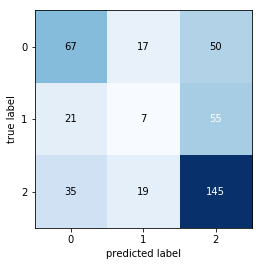

In [4]:
model = Sequential()
model.add(Dense(20, input_dim=len(X_h_train.columns), activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(3, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.fit(X_h_train, Y_keras_train, epochs=10000, batch_size=40)


predictions = model.predict_classes(X_h_test)
predictions
prd_df = pd.DataFrame(predictions, index=X_h_test.index, columns=['pred']) 

cm= confusion_matrix(Y_h_test, predictions)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()


# Next Game Predicitons

In [5]:
currentSeason = df.where(df.season == max(df.season)).dropna(how='all') 
nextGames = currentSeason.where(currentSeason.match_day == max(currentSeason.match_day)).dropna(how='all') 
ng_tp = pd.merge(nextGames.where(nextGames['was_home']== 1).dropna(how='all') , nextGames.where(df['was_home']== 0).dropna(how='all') , how='inner', on=['sf'])
ng_tp = pd.merge(team_lookup,ng_tp, how='inner', left_on=['id'], right_on=['opponent_team_id_x'])
ng_tp = pd.merge(team_lookup,ng_tp, how='inner', left_on=['id'], right_on=['team_id_x'])
ng_tp_prep = ng_tp[X_h_train.columns] 
ng_tp_prep = pd.DataFrame(scaler.fit_transform(ng_tp_prep), index=ng_tp_prep.index, columns=ng_tp_prep.columns) 

predictions = model.predict_proba(ng_tp_prep)
prd_df = pd.DataFrame(predictions, index=ng_tp_prep.index, columns=['Loss','Draw','Win']) 
prd_df = pd.merge(ng_tp[['name_x','name_y']],prd_df, how='inner', left_index=True, right_index=True)
qgrid.show_grid(prd_df,grid_options=grid_options,precision=2)

QgridWidget(grid_options={'maxVisibleRows': 15, 'editable': True, 'enableColumnReorder': False, 'minVisibleRow…